# Model Interpretability and Independent validation using model with transfer learning over independent validation dataset

In this notebook we are exploring the results of the clinical transformer to identify the important features (functional groups, feature permutation importance) as well as the impact on survival (Kapplan-Meier curves on the predicted populations). 

In [1]:
import sys
sys.path.append('/root/capsule/environment/clinical_transformer/')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import survival_attention_scores
from xai.models import load_transformer

2024-05-28 18:39:00.007389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 18:39:00.125901: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
from samecode.random import set_seed
import numpy as np 
import seaborn as sns

## Dataset

In [43]:
data = pd.read_csv('../data/dataset-train.data.csv')
data['sample_id'] = data.index
features = ["x_{}".format(i) for i in range(5)]

In [44]:
path = '../results/runs/TransferLearningSurvival/model.E001000.h5/'
run = 'fold-0_id-0'
sample_id = 'sample_id'
epoch = 40

In [45]:
trainer = load_transformer(path, run, epoch=epoch)
transformed_data = trainer.data_converter.transform(data).reset_index(drop=True)

In [46]:
set_seed(0)

evaluator = TransformerSurvivalEvaluator(model=trainer)

data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
    transformed_data, evaluator, iterations=1, sample_id=sample_id
)

100%|██████████| 700/700 [00:04<00:00, 160.53it/s]


## Funcional groups

In [47]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance as ssd
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
import numpy as np 

In [48]:
# # get overall cosine similarity
overall_cosine = attention_scores[(attention_scores.source != "<cls>") & (attention_scores.target != "<cls>")].groupby(['source', 'target']).mean()[['score']].reset_index()
overall_cosine.columns = ['source', 'target', 'cosine']

In [49]:
# overall_cosine

### Optimal clusters
In order to identify the optimal functional groups, we use the silhouette score across different cluster sizes and select the cluster number with the highest score. 

In [50]:
p1 = overall_cosine[['source', 'target', 'cosine']]
p2 = overall_cosine[['target', 'source', 'cosine']]
p2.columns = ['source', 'target', 'cosine']

p = pd.concat([p1, p2])

p['cosine'] = p.cosine
p = p.pivot_table(index='source', columns='target', values='cosine').fillna(1)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

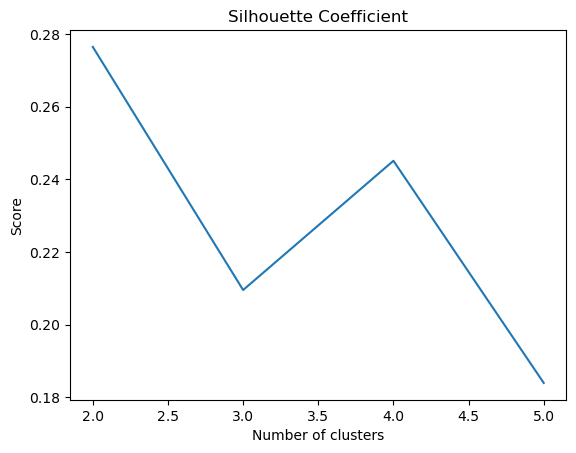

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'data' is your dataset
silhouette_scores = []
for i in range(2, 6):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(p)
    labels = kmeans.predict(p)
    score = silhouette_score(p, labels)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.plot(range(2, 6), silhouette_scores)
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.show()

### Visualization: Functional groups network based on optimal clusters

In [16]:
p1 = overall_cosine[['source', 'target', 'cosine']]
p2 = overall_cosine[['target', 'source', 'cosine']]
p2.columns = ['source', 'target', 'cosine']

p = pd.concat([p1, p2])

p['cosine'] = p.cosine
p = p.pivot_table(index='source', columns='target', values='cosine').fillna(1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(p)
p['cluster'] = kmeans.labels_
p['variable'] = p.index

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
clusters = p[['variable', 'cluster']].reset_index(drop=True).sort_values('cluster')
clusters = { i.variable: i.cluster for ix, i in clusters.iterrows()}

In [18]:
mls = overall_cosine[['source', 'target', 'cosine']]
mls['cluster'] = [clusters[i.source] if clusters[i.source] == clusters[i.target] else -1 for ix,i in mls.iterrows()]

In [19]:
from itertools import product

top=3
links = []
for c1x, c2x in list(product(range(6), range(6))):
    c1 = mls[mls.cluster == c1x]
    c2 = mls[mls.cluster == c2x]
    
    c1= list(set(list(c1.source) + list(c1.target)))
    c2= list(set(list(c2.source) + list(c2.target)))
    
    grp = mls[mls.source.isin(c1) & mls.target.isin(c2) & (mls.cluster == -1)].sort_values('cosine', ascending=False).reset_index(drop=True)[:top]
    
    grp['cosine'] = grp['cosine']
    
    links.append(grp)

In [20]:
links = pd.concat(links)

In [21]:
clr = pd.concat([mls[mls.cluster != -1], links])

In [22]:
clr['norm_cosine'] = (clr.cosine - np.min(clr.cosine)) / (np.max(clr.cosine) - np.min(clr.cosine))

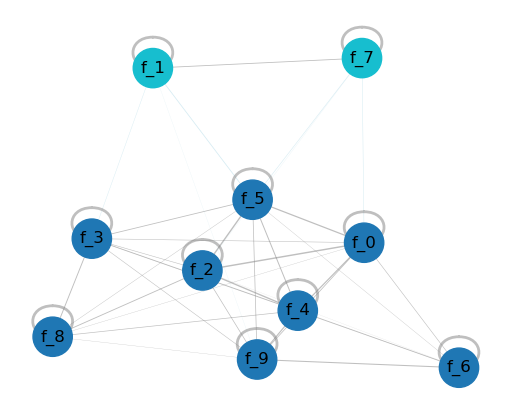

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
from samecode.plot.pyplot import subplots

# Create a sample network with source, target, weight, and group attributes
edges = np.array(clr)
groups = clusters

axs = subplots(cols=1, rows=1, w=5, h=4)

G = nx.Graph()
for edge in edges:
    source, target, weight, cluster, weight_n = edge
    G.add_edge(source, target, weight=weight_n, group=groups[source], edge_color = 'lightblue' if cluster == -1 else 'gray')

# Create a dictionary of node colors based on the group attribute
node_groups = {}
for node in G.nodes():
    group = groups[node]
    if group not in node_groups:
        node_groups[group] = len(node_groups)
    node_groups[node] = node_groups[group]
node_colors = [node_groups[node] for node in G.nodes()]

# Draw the network with nodes grouped by color and proximity
edgewidth = [ 2*d['weight'] for (u,v,d) in G.edges(data=True)]
edgecolor = [ d['edge_color'] for (u,v,d) in G.edges(data=True)]


pos = nx.spring_layout(G, k=1, iterations=200, seed=0)
# pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='tab10', node_size=800, alpha=1.0, ax=axs[0], )
nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.5, ax=axs[0], edge_color=edgecolor)
nx.draw_networkx_labels(G, pos, ax=axs[0])
plt.axis('off')
plt.show()

## Survival Analysis

In [24]:
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex
import seaborn as sns

### Training dataset

In [25]:
data = pd.read_csv('../data/dataset-train.data.csv')
data['sample_id'] = data.index

In [26]:
transformed_data = trainer.data_converter.transform(data).reset_index(drop=True)

In [27]:
set_seed(0)

evaluator = TransformerSurvivalEvaluator(model=trainer)

train_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
    transformed_data, evaluator, iterations=1, sample_id=sample_id
)

100%|██████████| 700/700 [00:04<00:00, 156.41it/s]


In [28]:
lfcindex(train_data['time'], train_data['β'], train_data['event'])

0.6932237813884786

### Define survival cutoffs

In [29]:
median_cutoff = np.quantile(train_data.β, 0.5)

### Testing dataset

In [30]:
data = pd.read_csv('../data/dataset-test.data.csv')
data['sample_id'] = data.index
features = ["x_{}".format(i) for i in range(5)]

In [31]:
transformed_data = trainer.data_converter.transform(data).reset_index(drop=True)

In [32]:
set_seed(0)

evaluator = TransformerSurvivalEvaluator(model=trainer)

test_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
    transformed_data, evaluator, iterations=10, sample_id=sample_id
)

100%|██████████| 300/300 [00:04<00:00, 73.44it/s]


In [33]:
test_data['population'] = (test_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])
train_data['population'] = (train_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])

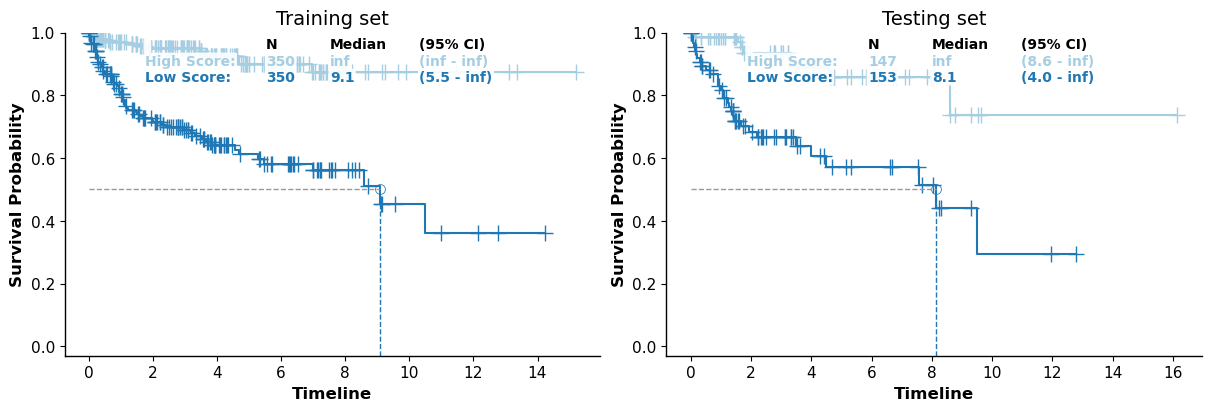

In [34]:
axs = subplots(cols=2, rows=1, w=12, h=4)
KMPlot(train_data, time='time', event='event', label=['population']).plot(ax=axs[0], title='Training set')
KMPlot(test_data, time='time', event='event', label=['population']).plot(ax=axs[1], title='Testing set')

In [35]:
lfcindex(train_data['time'], train_data['β'], train_data['event']), lfcindex(test_data['time'], test_data['β'], test_data['event'])

(0.6932237813884786, 0.6892439780586692)

## Feature Permutation Importance
Here we evaluate the individual impact of the input features. This along with the functional group analysis can help us to determine the contribution of the features and their interactions. 

In [36]:
%%capture
data = pd.read_csv('../data/dataset-test.data.csv')
data['sample_id'] = data.index

set_seed(0)
evaluator = TransformerSurvivalEvaluator(model=trainer)

feature_beta = []
for feature in trainer.features:
    for perm in range(2):
        f1v = np.array(data[feature])
        np.random.shuffle(f1v)
        
        datai = data.copy()
        datai[feature] = f1v
        
        transformed_data = trainer.data_converter.transform(datai).reset_index(drop=True)
        datai, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
            transformed_data, evaluator, iterations=1, sample_id=sample_id
        )
        
        datai['feature'] = feature
        
        cindex = lfcindex(datai['time'], datai['β'], datai['event'])
        feature_beta.append({'feature': feature, 'cindex': cindex, 'perm': perm})

In [37]:
feature_beta = pd.DataFrame(feature_beta)

In [38]:
cindex = lfcindex(test_data['time'], test_data['β'], test_data['event'])

In [39]:
feature_beta['delta'] = cindex - feature_beta.cindex

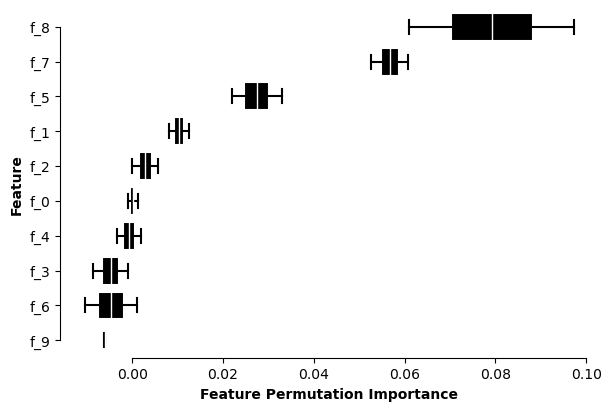

In [40]:
axs = subplots(cols=1, rows=1, w=6, h=4)

PROPS = {
    'boxprops':{'facecolor':'#000000', 'edgecolor':'white'},
#     'boxprops':{'edgecolor':'white'},
    'medianprops':{'color':'white', 'linewidth': 1},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

order = feature_beta.groupby('feature').median().reset_index().sort_values('delta', ascending=False).feature
ax = sns.boxplot(data=feature_beta, y='feature', x='delta', order=order, ax=axs[0], **PROPS);
sns.despine(offset=0, trim=True);
axs[0].set_xlabel('Feature Permutation Importance', weight='bold');
axs[0].set_ylabel('Feature', weight='bold');